In [2]:
import findspark
findspark.init()

# create spark session
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("my app").master("local").getOrCreate()

# get context from the session
sc = spark.sparkContext

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time

# Misc

In [12]:
def create_setdata(ss):
    record = set()
    for i in ss:
        if i not in record:
            record.add(i)
        else:
            yield record
            record = set()
            record.add(i)
    if not record:
        yield record

In [13]:
def create_dataset(N):
    """
    N개의 하이퍼링크 페이지 생성
    """
    
    while True:
        s = np.random.default_rng().zipf(1.2, N * 10 * 10)
        dataset = list(create_setdata(s[s<N]))
        if len(dataset) >=N:
            break

    ids = range(N)
    return [ (i, s) for i, s in zip(ids, dataset[:N]) ]

# Algorithm

In [21]:
from operator import add

def comp_pagerank(sc, dataset, d=0.85, convergenceTol=0.00001, maxIter=50):
    N = len(dataset)
    
    pr_local = [ 1. / float(N) for _ in range(N) ]
    inputRDD = sc.parallelize(dataset).cache()
    jumpPr = sc.parallelize([ (pid, 1. / float(N) * (1. - d)) for pid in range(N) ]).cache()

    for iterNo in range(maxIter):
        # broacast current pagerank values
        pr = sc.broadcast(pr_local)
        
        itr = inputRDD\
                .flatMap(lambda t: [ (target, d * pr.value[t[0]] / float(len(t[1]))) for target in t[1] ])\
                .union(jumpPr)\
                .reduceByKey(add).cache()

        # test convergence
        err = itr.map(lambda t: abs(pr.value[t[0]] - t[1])).sum() / N

        # release previously broadcast pagerank array
        pr.destroy()
        pr_local = itr.map(lambda t: t[1]).collect()

        if err < convergenceTol: 
            break
        
    return pr_local

# Evaluation

In [22]:
Ns = [1000, 2000, 4000, 8000, 16000]

In [23]:
execution_time = list()

for N in Ns:
    local = create_dataset(N)

    start_time = time.time()
    comp_pagerank(sc, local)
    execution_time.append(time.time() - start_time)

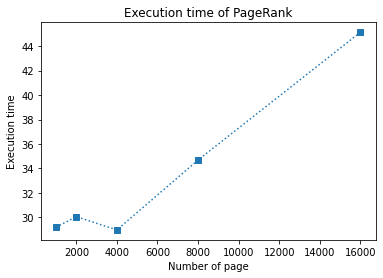

In [24]:
plt.xlabel("Number of page")
plt.ylabel("Execution time")
plt.title("Execution time of PageRank")
plt.plot(Ns, execution_time, linestyle=':', marker='s')
plt.show()